In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import timedelta
from datetime import datetime
import dask.array

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')
folder_debris = os.path.join(folder_AGVA, 'debris cover', 'raster')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# load rgi names that have been saved to the classified folder
rgis_folder = list(set( [ i[3:17] for i in os.listdir(folder_class) if i!='merged.vrt' ] ))

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

# get rgi names for given o2 region
rgis_o2 = rgi_gdf[rgi_gdf['O2Region']=='4']['RGIId'].values

# select which rgis to analyze
if validation_only:
    rgis_to_analyze = list( set(rgis_folder).intersection(set(all_validation_df['RGIId'].values)) )
else:
    # rgis_to_analyze = ["RGI60-01.09162"] # just a single rgi
    rgis_to_analyze = rgis_folder # everything that is available
#     rgis_to_analyze = list( set(rgis_folder).intersection(set(rgis_o2)) ) # all the rgis in the folder than are in this o2region

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

3031


In [107]:
c = 0
for i in range(len(rgis_to_analyze)):
#     if c>0: continue
#     if i<43: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
    if rgiid!= "RGI60-01.10907": continue #10910 08989

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]

#     if ga<332: continue
#     if ga<3300: continue
        
    # set folder
    if validation_only:
        folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
    else:
        folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')
       
    # check if this glacier has been run already, skip if so
#     temp_path = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_2022_daily_AAs_shadowed.nc")
#     if os.path.exists(temp_path): continue
        
    # check if the initial products we need exist yet. if not, then continue
    path_1 = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_2022_daily_AAs.nc")
    path_2 = os.path.join(folder_save, 'Shadows', f"S2_{rgiid}_2022_daily_shadows.nc")
    if not os.path.exists(path_1): continue
    if not os.path.exists(path_2): continue
    
    # print progress
    print(f"\nStarting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # grab just this rgi geometry and info
    rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
    single_geometry = rgi_single.geometry

    # single_geometry = single_geometry.buffer(-100) #what if we buffer out the exterior 100 meters of the glacier
 
    # open glacier mask, count how many pixels there are
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    # open the observed faction df
#     obs_path = os.path.join(folder_save, 'Daily AAs', 'observed', f"S2_{rgiid}_observed.csv")
#     obs_df = pd.read_csv(obs_path)
    
    # for each year, open the daily data, calculate frequencies, save
    useable_ns = []
    debris_ns = []
    water_ns = []
    for y in [2018,2019,2020,2021,2022]:
        
#         if ga>100: print(y)
#         if y!=2022: continue
        
        # open data
        path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{y}_daily_AAs.nc")
        path_shadow = os.path.join(folder_save, 'Shadows', f"S2_{rgiid}_{y}_daily_shadows.nc")
        path_debris = os.path.join(folder_debris, f"{rgiid}_debris.tif")
        
        # if small glacier, we dont need to chunk
        if ga>1000:
            snow = xr.open_dataset(path_open, chunks={'time':1})
            shadows = xr.open_dataset(path_shadow, chunks={'time':1})
            debris = riox.open_rasterio(path_debris)
        elif ga>100:
            snow = xr.open_dataset(path_open, chunks={'time':10})
            shadows = xr.open_dataset(path_shadow, chunks={'time':10})
            debris = riox.open_rasterio(path_debris)
        else:
            snow = xr.open_dataset(path_open)
            shadows = xr.open_dataset(path_shadow)
            debris = riox.open_rasterio(path_debris)
        
        # at this point:
        # snow=0 is off-glacier, shadow, cloud
        # snow=1 is snow
        # snow=2,3,4,6 is firn,ice,debris,water (in that order) (5 is shadow)
        # terrain shadow mask has 1=usable, 0=shadow or off-glacier
        # debris mask has 1=debris, 0=not debris
        
        # calculate the frequency at which each pixel is identified as debris, water, when not snow
        useable_ns.append( xr.where( snow.isin([2,3,4,6]) & (shadows==1), 1, 0 ).sum('time').to_array() )
        debris_ns.append( xr.where( (snow==4) & (shadows==1), 1, 0).sum('time').to_array() )
        water_ns.append( xr.where( (snow==6) & (shadows==1), 1, 0).sum('time').to_array() )
    
    useable_all = np.sum(useable_ns, axis=1)[0]
    debris_f = np.sum(debris_ns, axis=1)[0]/useable_all
    water_f = np.sum(water_ns, axis=1)[0]/useable_all
    debriswater_f = debris_f+water_f
    
    water_18 = (water_ns[0]/useable_ns[0])[0]
    water_22 = (water_ns[-1]/useable_ns[-1])[0]
#     water_diff = water_22-water_18
        
    c+=1
print("Done!")
# should start at 1953, 6.217 km2


Starting 2926 of 3031: RGI60-01.10907  137.956 km2
2018
2019
2020
2021
2022


C:\Users\lzell\AppData\Local\Temp\ipykernel_18944\2974593487.py:88: RuntimeWarning: invalid value encountered in divide
  debris_f = np.sum(debris_ns, axis=1)[0]/useable_all


Done!


C:\Users\lzell\AppData\Local\Temp\ipykernel_18944\2974593487.py:89: RuntimeWarning: invalid value encountered in divide
  water_f = np.sum(water_ns, axis=1)[0]/useable_all


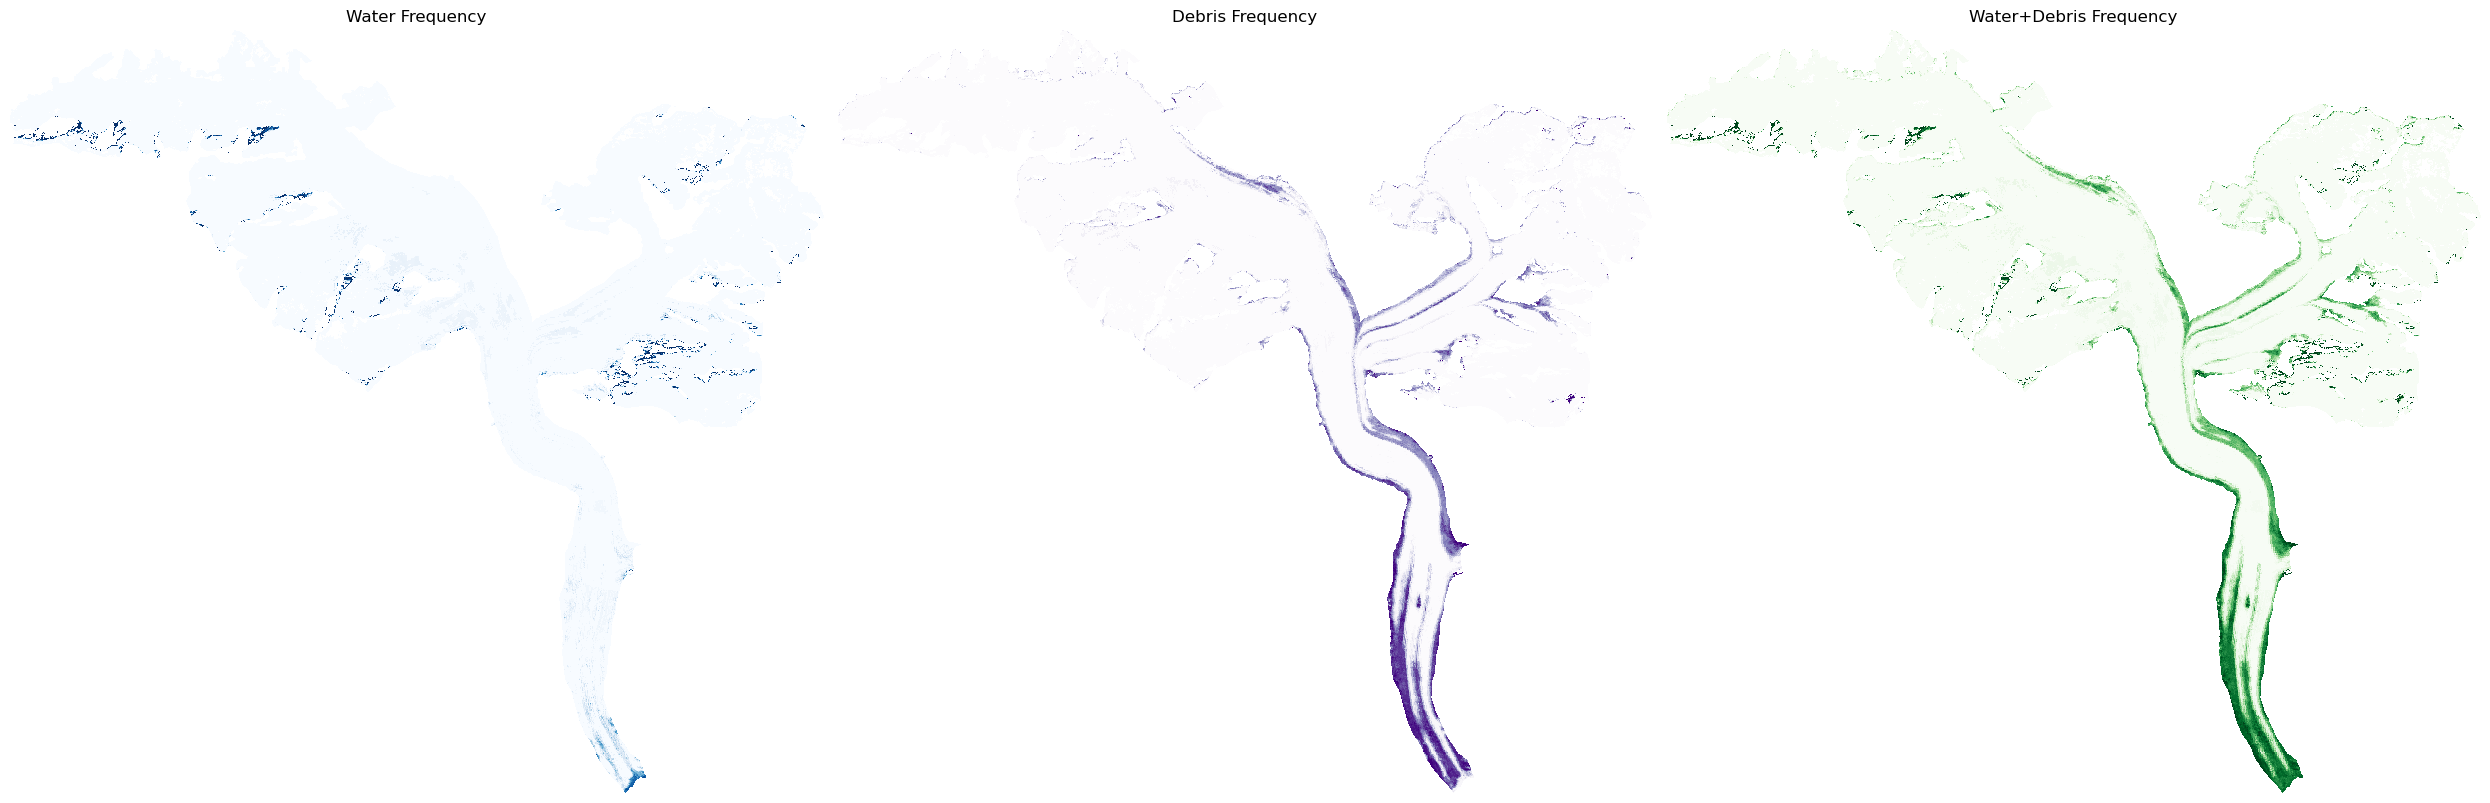

In [108]:
fig,axs = plt.subplots(1,3, figsize=(25,25))
axs[0].imshow(water_f, cmap='Blues', vmin=0, vmax=1, interpolation='none')
axs[1].imshow(debris_f, cmap='Purples', vmin=0, vmax=1, interpolation='none')
axs[2].imshow(debriswater_f, cmap='Greens', vmin=0, vmax=1, interpolation='none')

axs[0].set_title('Water Frequency')
axs[1].set_title('Debris Frequency')
axs[2].set_title('Water+Debris Frequency')

for ax in axs:
    ax.axis('off')
plt.tight_layout()

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


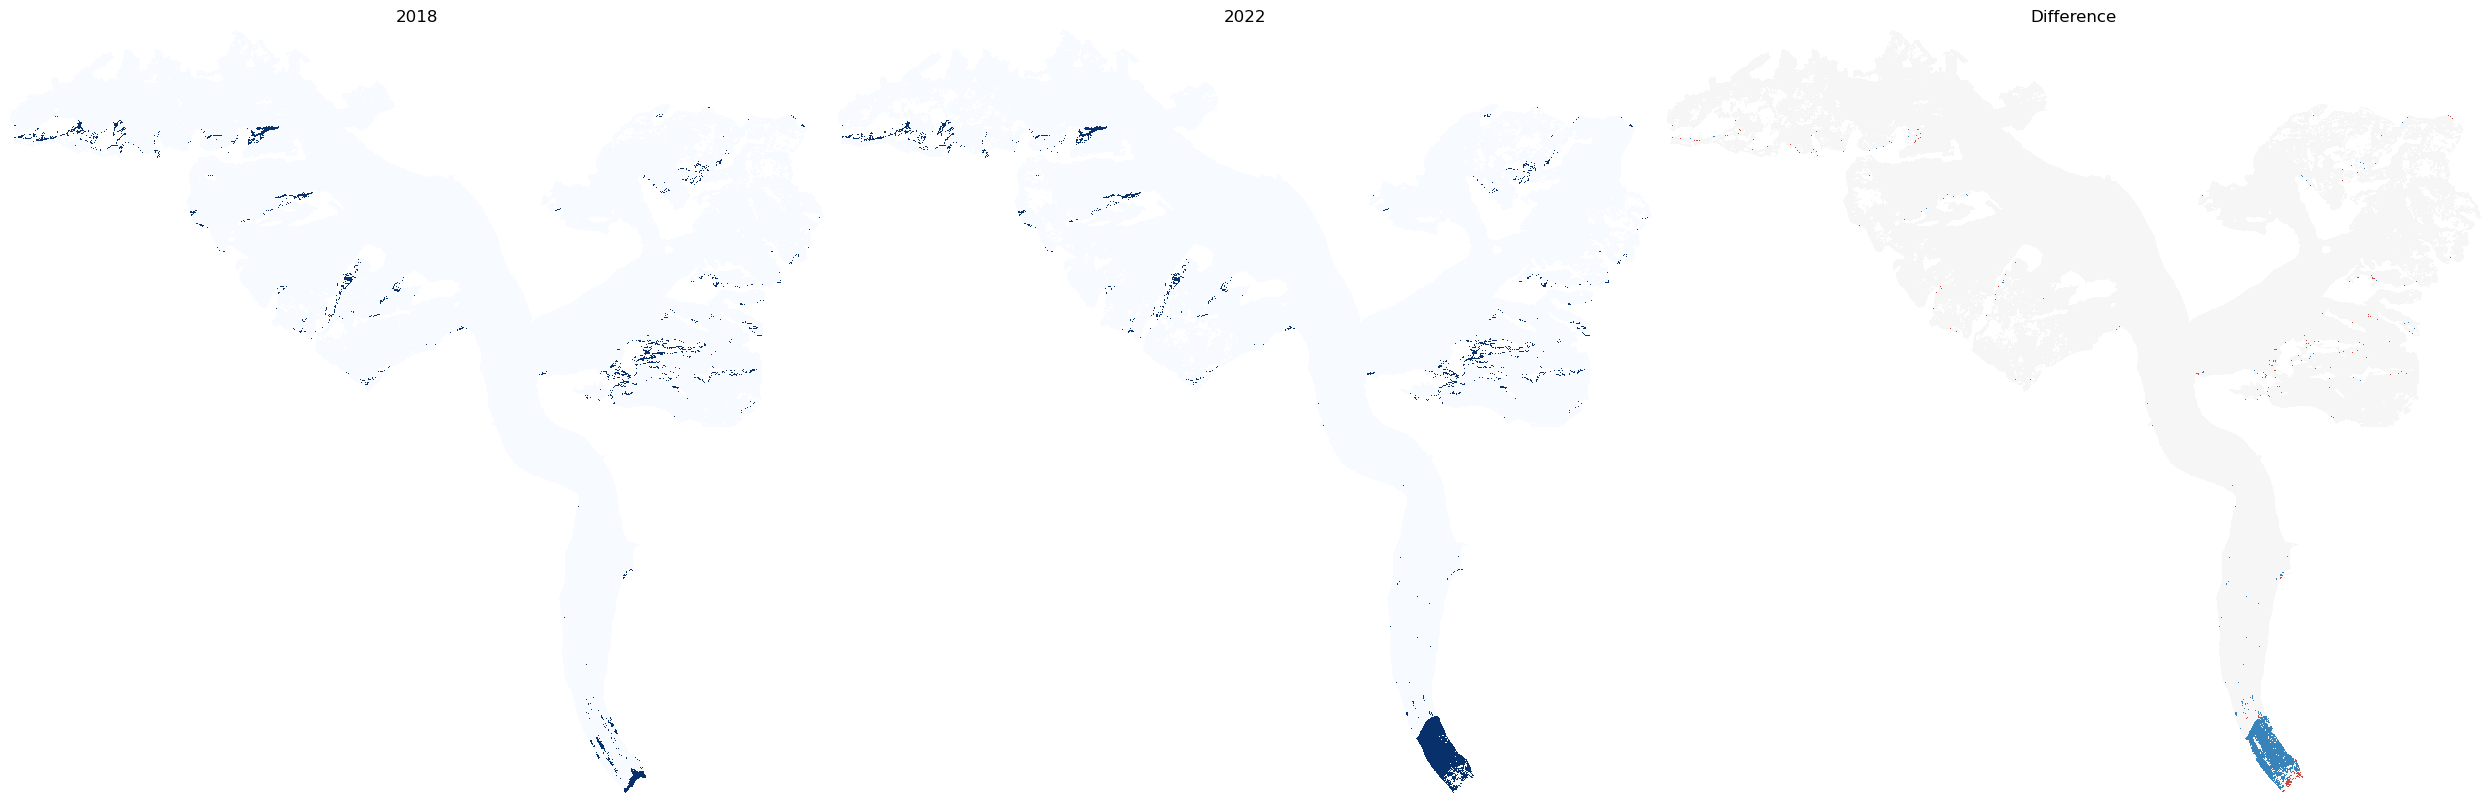

In [109]:
water_18_mask = np.round(water_18+0.2)
water_22_mask = np.round(water_22+0.2)
water_diff_mask = water_22_mask-water_18_mask

fig,axs = plt.subplots(1,3, figsize=(25,25))
axs[0].imshow(water_18_mask, cmap='Blues', vmin=0, vmax=1, interpolation='none')
axs[1].imshow(water_22_mask, cmap='Blues', vmin=0, vmax=1, interpolation='none')
axs[2].imshow(water_diff_mask, cmap='RdBu', vmin=-1.5, vmax=1.5, interpolation='none')

axs[0].set_title('2018')
axs[1].set_title('2022')
axs[2].set_title('Difference')

for ax in axs:
    ax.axis('off')
plt.tight_layout()